<a href="https://colab.research.google.com/github/jdbioinf/bio-chem-informatics/blob/main/RandomForest_Chembl_p53.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ChEMBL Drug Discovery (p53)

In this project, the official [chembl_webresource_client](https://github.com/chembl/chembl_webresource_client) Python module developed by ChEMBL will be used to download data from [ChEMBL](https://www.ebi.ac.uk/chembl/) and analysed for its vialibity as a therapeutic.

In this version of the project, p53, a powerful tumour suppressor and one of the most commonly mutated genes in human cancer, is used as the target of interest. As a transcription factor, p53 is a difficult therapeutic target, however it has gained interest in recent years due to [increasing understanding of p53](https://www.nature.com/articles/s41573-022-00571-8) and [new emerging methods of targeting p53](https://aacrjournals.org/cancerres/article/82/3/362/678027/Targeting-the-P53-Protein-for-Cancer-Therapies-The). Computational models are well suited to mining the growing quantities of public information surrounding p53 assay. This project is a basic example of how such investigations could be conducted, and could be adapted as more data becomes available:

1. Find compounds which have been tested for activity against p53
2. Filter these compounds based on drug-likeness (Lipinski Rule of Five)
3. Identify key Lipinski features which seem to contribute to activity
4. Extract molecular fingerprints of molecules tested
5. Train a regression model to predict activity of molecules based on molecular fingerprints

PD-1 was also assessed as the target of interest as this is an immune checkpoint protein present on the surface of T cells (and B cells) which, in healthy individuals functions to regulate the immune response and prevent autoimmunity, but can alo [prevent immune cells effectively killing tumour cells](https://www.nature.com/articles/nri.2017.108). However, the number of datapoints for this protein was insufficient to perform training.



## Specical Modules Used



* [chembl_webresource_client](https://github.com/chembl/chembl_webresource_client) - chemoinformatics libary for interacting with ChEMBL data
* [rdkit](https://rdkit.org/docs/) - chemoinformatics toolkit for accessing molecular information
* [pubchempy](https://pubchempy.readthedocs.io/en/latest/) - allows chemical searches by name, substructure and similarity, chemical standardization, conversion between chemical file formats, depiction and retrieval of chemical properties
* [lazypredict](https://lazypredict.readthedocs.io/en/latest/usage.html) - simplifies training, testing and evaluating multiple machine learning models

## Module Set Up

In [1]:
# If necessary install special modules
try:
  from chembl_webresource_client.new_client import new_client
  import rdkit
  import pubchempy as pcp
  import padelpy
except:
  !pip install chembl_webresource_client
  !pip install rdkit
  !pip install pubchempy
  !pip install lazypredict
  ! pip install padelpy
  from chembl_webresource_client.new_client import new_client
  import rdkit
  import pubchempy as pcp
  import padelpy

# Import other required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import tqdm
import lazypredict
import multiprocessing
import math
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from lazypredict.Supervised import LazyRegressor

# # Download PaDEL-Descriptor (v0.1.15)
! wget https://github.com/ecrl/padelpy/archive/refs/tags/0.1.15.zip
! unzip 0.1.15.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13819 sha256=2ae17b93adc736f2f4cf8435b1567d4922347e7b7268da683e2bcea61c8fe3f4
  Stored in directory: /root/.cache/pip/wheels/90/7c/45/18a0671e3c3316966ef7ed9ad2b3f3300a7e41d3421a44e799
Successfully built pubchempy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 60.6 MB/s eta 0:00:00
--2024-02-26 18:27:53--  https://github.com/ecrl/padelpy/archive/refs/tags/0.1.15.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location:

In [2]:
# List available data from chembl_webresource_client.new_client
available_resources = [resource for resource in dir(new_client) if not resource.startswith('_')]
print(available_resources)

['activity', 'activity_supplementary_data_by_activity', 'assay', 'assay_class', 'atc_class', 'binding_site', 'biotherapeutic', 'cell_line', 'chembl_id_lookup', 'compound_record', 'compound_structural_alert', 'description', 'document', 'document_similarity', 'drug', 'drug_indication', 'drug_warning', 'go_slim', 'image', 'mechanism', 'metabolism', 'molecule', 'molecule_form', 'official', 'organism', 'protein_classification', 'similarity', 'source', 'substructure', 'target', 'target_component', 'target_relation', 'tissue', 'xref_source']


## Inspect And Curate Data

In [3]:
search_term = "p53"
target = new_client.target
target_query = target.search(search_term) # search for target protein
targets = pd.DataFrame.from_dict(target_query)
targets.head(20)

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P04637', 'xref_name': None, 'xre...",Homo sapiens,Cellular tumor antigen p53,17.00,False,CHEMBL4096,"[{'accession': 'P04637', 'component_descriptio...",SINGLE PROTEIN,9606
1,"[{'xref_id': 'P02340', 'xref_name': None, 'xre...",Mus musculus,Cellular tumor antigen p53,16.00,False,CHEMBL4164,"[{'accession': 'P02340', 'component_descriptio...",SINGLE PROTEIN,10090
2,[],Homo sapiens,Tumour suppressor protein p53/Mdm4,16.00,False,CHEMBL2221344,"[{'accession': 'P04637', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606
3,[],Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,15.00,False,CHEMBL1907611,"[{'accession': 'P04637', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606
4,[],Homo sapiens,CREB-binding protein/p53,15.00,False,CHEMBL3301383,"[{'accession': 'P04637', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606
5,[],Homo sapiens,MDM2/MDMX-p53,15.00,False,CHEMBL3883306,"[{'accession': 'P04637', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606
6,[],Homo sapiens,Cellular tumor antigen p53/Death-associated pr...,15.00,False,CHEMBL3885543,"[{'accession': 'P04637', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606
7,[],Homo sapiens,Cellular tumor antigen p53/Peptidyl-prolyl cis...,14.00,False,CHEMBL3885544,"[{'accession': 'P04637', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606
8,[],Homo sapiens,p53 mRNA,14.00,False,CHEMBL4622827,"[{'accession': 'ENSG00000141510', 'component_d...",NUCLEIC-ACID,9606
9,[],Homo sapiens,Cereblon/Tumour suppressor p53/oncoprotein Mdm2,14.00,False,CHEMBL4879538,"[{'accession': 'P04637', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606


In [4]:
print(f"There are {len(targets)} results for {search_term} involving {len(targets.organism.unique())} organisms")

There are 37 results for p53 involving 3 organisms


In [5]:
# let's look at a search result (for esearch of pd1 indexes 1 and 5 work ok, for p53 index 3 works well)
target_of_interest = targets.target_chembl_id[3] # index 1 is a protein complex - select this as target
print(f"Selected ChEMBL target is {target_of_interest}")

Selected ChEMBL target is CHEMBL1907611


In [6]:
# Create client for activity search
# Select a compound (in this case the p53 protein complex) and search for activity against it
# Then filter bioactivity unit of IC50
# Then filter for assay type B (binding)
activity = new_client.activity
res = activity.filter(target_chembl_id=target_of_interest, standard_type="IC50", assay_type="B")
res_df = pd.DataFrame.from_dict(res)
print(f"{len(res)} Results activity results from binding assay for {target_of_interest} with IC50 values")
print(f"Assay descriptions for {target_of_interest}:\n{res_df['assay_description'].unique()}")
res_df.head(10)

1621 Results activity results from binding assay for CHEMBL1907611 with IC50 values
Assay descriptions for CHEMBL1907611:
['Inhibitory concentration against MDM2-p53 interaction in SJSA human sarcoma cells'
 'Inhibition of p53-binding to HDM2 (human MDM2) by fluorescence polarization peptide displacement assay'
 'In vitro inhibitory concentration against p53-mdm2 interaction'
 'In vitro inhibitory concentration against p53-mdm2 interaction; Range = 9.6 to 14 uM'
 'Inhibitory activity against MDM2 (murine double minute-2 gene) binding to p53'
 'Inhibition of p53-MDM2 interaction by ELISA'
 'Inhibition of human MDM2/P53 interaction by HTRF assay'
 'Inhibition of human GST-fused HDM2-p53 protein-protein interaction by HTRF assay'
 'Inhibition of human MDM2-p53 interaction after 20 mins by ELSA method'
 'Competitive inhibition of MDM2/P53 interaction after 1 hr by fluorescence polarization assay'
 'Inhibition of p53 (18 to 26)-MDM2 (2 to 188) interaction using fluorescent dye Cy5 by TR-FRE

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,1424130,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,27.0
1,None,None,1424131,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,66.0
2,None,None,1424132,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,90.0
3,None,None,1424135,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,85.0
4,None,None,1424136,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,92.0
5,None,None,1424137,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,70.0
6,None,None,1424233,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,15.9
7,None,None,1424234,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,92.0
8,None,None,1424235,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,14.0
9,None,None,1424236,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,26.2


In [7]:
print(res_df.columns)

Index(['action_type', 'activity_comment', 'activity_id', 'activity_properties',
       'assay_chembl_id', 'assay_description', 'assay_type',
       'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint',
       'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment',
       'data_validity_description', 'document_chembl_id', 'document_journal',
       'document_year', 'ligand_efficiency', 'molecule_chembl_id',
       'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id',
       'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_organism',
       'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type',
       'units', 'uo_units', 'upper_value', 'value'],
      dtype='object')


In [8]:
print(f"Dataset standard types are {res_df.standard_type.unique()}")
print(f"Dataset assay types are {res_df.assay_type.unique()}")
res_df = res_df.dropna(subset=["standard_flag","molecule_chembl_id","canonical_smiles","standard_value"])
res_df = res_df[res_df["canonical_smiles"] != "NaN"]
print(f"{len(res_df)} rows remaining after removing rows with NaN values")

Dataset standard types are ['IC50']
Dataset assay types are ['B']
1620 rows remaining after removing rows with NaN values


Save raw data containing SMILES format and standard flags - save to csv, also save selection of interest to csv

In [9]:
data_path = Path("drug_discovery/data/")
csv_path = data_path / "csvs"
plot_path = data_path / "plots"
if not Path.exists(data_path):
  data_path.mkdir(parents=True, exist_ok=True)
if not Path.exists(csv_path):
  csv_path.mkdir(parents=True, exist_ok=True)
if not Path.exists(plot_path):
  plot_path.mkdir(parents=True, exist_ok=True)
res_df.to_csv(csv_path / "bioactivity_data_raw.csv",index=False)

In [10]:
# Remove all columns except those that will be used for chemoinformatics testing
res_df = res_df[["standard_value", "molecule_chembl_id", "canonical_smiles"]]
res_df

,standard_value,molecule_chembl_id,canonical_smiles
0,27000.0,CHEMBL179549,CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccc(C(C)(C)C)cc1)...
1,66000.0,CHEMBL360920,CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccccc1)c1ccc(C(C)...
2,90000.0,CHEMBL182052,CCCOC1(c2ccccc2)c2ccccc2C(=O)N1C(Cc1ccc(O)cc1)...
3,85000.0,CHEMBL179662,OCC(NC1(c2ccccc2)c2ccccc2CC1Cc1ccccc1)C(O)c1cc...
4,92000.0,CHEMBL181688,CC(C)(C)c1ccc(COC2(c3ccccc3)c3ccccc3C(=O)N2Cc2...
...,...,...,...
1616,0.6,CHEMBL3125702,CC(C)[C@@H](CS(=O)(=O)C(C)C)N1C(=O)[C@@](C)(CC...
1617,10.6,CHEMBL2313487,COc1cc(Cc2c(-c3ccn(S(=O)(=O)c4ccccc4)c3)[nH]c3...
1618,7.85,CHEMBL4095983,O=C(CC(c1ccccc1)c1ccccc1)N[C@@H](Cc1ccc(OCCCNc...
1619,18.7,CHEMBL191334,COc1ccc(C2=N[C@@H](c3ccc(Cl)cc3)[C@@H](c3ccc(C...


Add bioactivity information based on IC50 values

In [11]:
res_df.standard_value

0       27000.0
1       66000.0
2       90000.0
3       85000.0
4       92000.0
         ...   
1616        0.6
1617       10.6
1618       7.85
1619       18.7
1620       17.3
Name: standard_value, Length: 1620, dtype: object

In [12]:
bioactivity_threshold = []
for i in res_df.standard_value: # specify bioactivity based on IC50 value
  if float(i) >= 10000:
    bioactivity_threshold.append("inactive")
  elif float(i) <= 1000:
    bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("intermediate")
bioactivity_series = pd.Series(bioactivity_threshold, name="bioactivity_class")
res_df = pd.concat([res_df, bioactivity_series], axis = 1) # add series along column axis
res_df.to_csv(csv_path / "bioactivity_data_preprocessed.csv", index=False)
res_df

,standard_value,molecule_chembl_id,canonical_smiles,bioactivity_class
0,27000.0,CHEMBL179549,CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccc(C(C)(C)C)cc1)...,inactive
1,66000.0,CHEMBL360920,CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccccc1)c1ccc(C(C)...,inactive
2,90000.0,CHEMBL182052,CCCOC1(c2ccccc2)c2ccccc2C(=O)N1C(Cc1ccc(O)cc1)...,inactive
3,85000.0,CHEMBL179662,OCC(NC1(c2ccccc2)c2ccccc2CC1Cc1ccccc1)C(O)c1cc...,inactive
4,92000.0,CHEMBL181688,CC(C)(C)c1ccc(COC2(c3ccccc3)c3ccccc3C(=O)N2Cc2...,inactive
...,...,...,...,...
1617,10.6,CHEMBL2313487,COc1cc(Cc2c(-c3ccn(S(=O)(=O)c4ccccc4)c3)[nH]c3...,active
1618,7.85,CHEMBL4095983,O=C(CC(c1ccccc1)c1ccccc1)N[C@@H](Cc1ccc(OCCCNc...,active
1619,18.7,CHEMBL191334,COc1ccc(C2=N[C@@H](c3ccc(Cl)cc3)[C@@H](c3ccc(C...,active
1620,17.3,CHEMBL3220312,Cc1c(Cl)ccc2c(/C=C3\NC(=O)N(C(C(=O)NC(CO)CO)c4...,NaN


In [13]:
# Canonical SMILES column
print(res_df["canonical_smiles"])
print(len(res_df["canonical_smiles"][0]))
print(res_df["canonical_smiles"][0])

0       CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccc(C(C)(C)C)cc1)...
1       CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccccc1)c1ccc(C(C)...
2       CCCOC1(c2ccccc2)c2ccccc2C(=O)N1C(Cc1ccc(O)cc1)...
3       OCC(NC1(c2ccccc2)c2ccccc2CC1Cc1ccccc1)C(O)c1cc...
4       CC(C)(C)c1ccc(COC2(c3ccccc3)c3ccccc3C(=O)N2Cc2...
                              ...                        
1617    COc1cc(Cc2c(-c3ccn(S(=O)(=O)c4ccccc4)c3)[nH]c3...
1618    O=C(CC(c1ccccc1)c1ccccc1)N[C@@H](Cc1ccc(OCCCNc...
1619    COc1ccc(C2=N[C@@H](c3ccc(Cl)cc3)[C@@H](c3ccc(C...
1620    Cc1c(Cl)ccc2c(/C=C3\NC(=O)N(C(C(=O)NC(CO)CO)c4...
1443                                                  NaN
Name: canonical_smiles, Length: 1621, dtype: object
72
CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccc(C(C)(C)C)cc1)c1ccc(OCOCC[Si](C)(C)C)cc1


In [14]:
df_no_smiles = res_df.drop(columns='canonical_smiles')
smiles = []
# pick the maximum SMILES text length for each compound
for i in res_df.canonical_smiles.tolist():
  compound = str(i).split('.')
  compound_longest = max(compound, key = len)
  smiles.append(compound_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')
print(smiles)

0       CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccc(C(C)(C)C)cc1)...
1       CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccccc1)c1ccc(C(C)...
2       CCCOC1(c2ccccc2)c2ccccc2C(=O)N1C(Cc1ccc(O)cc1)...
3       OCC(NC1(c2ccccc2)c2ccccc2CC1Cc1ccccc1)C(O)c1cc...
4       CC(C)(C)c1ccc(COC2(c3ccccc3)c3ccccc3C(=O)N2Cc2...
                              ...                        
1616    COc1cc(Cc2c(-c3ccn(S(=O)(=O)c4ccccc4)c3)[nH]c3...
1617    O=C(CC(c1ccccc1)c1ccccc1)N[C@@H](Cc1ccc(OCCCNc...
1618    COc1ccc(C2=N[C@@H](c3ccc(Cl)cc3)[C@@H](c3ccc(C...
1619    Cc1c(Cl)ccc2c(/C=C3\NC(=O)N(C(C(=O)NC(CO)CO)c4...
1620                                                  nan
Name: canonical_smiles, Length: 1621, dtype: object


In [15]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1).dropna()


## Determine Drug-Likeness of Compounds

The Lipinski Rule Of Five for orally active drugs will be used for this (although not all orally administered drugs actually adhere to this).

The components of this rule dictate that no **orally administered drug compound** should violate no more than one of the following criteria:
1. No more than 5 hydrogen bond donors (the total number of nitrogen–hydrogen and oxygen–hydrogen bonds)
2. No more than 10 hydrogen bond acceptors (all nitrogen or oxygen atoms)
3. A molecular mass less than 500 Daltons
4. A calculated octanol-water partition coefficient (Clog P) that does not exceed 5

This rule ensures that candidate drug compounds have a pharmocokinetic profile that has suitable absorption, distribution, metabolism and excretion (ADME) for administration to human patients.

In [16]:
#Lipinski.NumHAcceptors?

In [17]:
# DataFrame contains 855 rows so select only first 200 for speed when testing
# df_clean_smiles = df_clean_smiles.head(200)

In [18]:
def get_lipinski_stats_for_SMILES_list(in_smiles: list) -> pd.DataFrame:
  """Generates a Pandas DataFrame containing the Lipinski Rule of Five statistics.
  Required input is a list of SMILES strings"""
  molecules = []
  pbar = tqdm.tqdm(in_smiles)
  for compound in pbar:
    molecules.append(Chem.MolFromSmiles(compound)) # Construct a molecule from a SMILES string
  descriptors = pd.DataFrame()
  pbar = tqdm.tqdm(molecules)
  count = 0
  for molecule in pbar:
    descriptor_dict = {}
    descriptor_dict["MW"] = [Descriptors.MolWt(molecule)] # The average molecular weight of the molecule
    descriptor_dict["LogP"] = [Descriptors.MolLogP(molecule)] # Wildman-Crippen LogP value
    descriptor_dict["NumHDonors"] = [Lipinski.NumHDonors(molecule)] # Number of Hydrogen Bond Donors
    descriptor_dict["NumHAcceptors"] = [Lipinski.NumHAcceptors(molecule)] # Number of Hydrogen Bond Acceptors
    descriptors = descriptors.append(pd.DataFrame.from_dict(descriptor_dict)) # add molecule data to dataframe
  return descriptors

In [19]:
# Use multiprocessing to compute lipinski statistics in batches of 100 (increases speed)
in_data = df_clean_smiles["canonical_smiles"]
in_smiles_batches = [in_data[i:i+100] for i in range(0,len(in_data),100)]
with multiprocessing.Pool(10) as p:
  df_lipinski = pd.concat(p.map(get_lipinski_stats_for_SMILES_list, in_smiles_batches), axis=0)
print(df_lipinski)

  2%|▏         | 2/100 [00:00<00:06, 15.85it/s]

100%|██████████| 100/100 [00:02<00:00, 43.10it/s]

100%|██████████| 100/100 [00:02<00:00, 42.31it/s]


100%|██████████| 100/100 [00:00<00:00, 176.11it/s]

100%|██████████| 100/100 [00:01<00:00, 93.15it/s]


       MW  LogP  NumHDonors  NumHAcceptors
0  572.82  7.17           1              4
0  426.56  5.48           1              2
0  445.52  4.26           1              5
0  449.59  5.03           3              3
0  461.61  7.06           0              2
..    ...   ...         ...            ...
0  568.56  6.38           1              4
0  502.59  5.49           1              6
0  523.63  5.30           3              5
0  581.50  5.89           1              5
0  518.90  2.51           5              5

[1619 rows x 4 columns]


In [20]:
# Add Lipinski data to other data, and remove NA values
df_combined_lipinski = pd.concat([res_df.reset_index(drop=True),df_lipinski.reset_index(drop=True)], axis=1)
df_combined_lipinski["standard_value"] = df_combined_lipinski["standard_value"].astype(float)
df_combined_lipinski = df_combined_lipinski.dropna()
df_combined_lipinski

,standard_value,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,27000.00,CHEMBL179549,CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccc(C(C)(C)C)cc1)...,inactive,572.82,7.17,1.00,4.00
1,66000.00,CHEMBL360920,CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccccc1)c1ccc(C(C)...,inactive,426.56,5.48,1.00,2.00
2,90000.00,CHEMBL182052,CCCOC1(c2ccccc2)c2ccccc2C(=O)N1C(Cc1ccc(O)cc1)...,inactive,445.52,4.26,1.00,5.00
3,85000.00,CHEMBL179662,OCC(NC1(c2ccccc2)c2ccccc2CC1Cc1ccccc1)C(O)c1cc...,inactive,449.59,5.03,3.00,3.00
4,92000.00,CHEMBL181688,CC(C)(C)c1ccc(COC2(c3ccccc3)c3ccccc3C(=O)N2Cc2...,inactive,461.61,7.06,0.00,2.00
...,...,...,...,...,...,...,...,...
1614,72.00,CHEMBL4169540,N=C(N)Nc1cccc(C(=O)NCC(=O)N[C@@H](CC(=O)O)C(=O...,active,568.56,6.38,1.00,4.00
1615,0.60,CHEMBL3125702,CC(C)[C@@H](CS(=O)(=O)C(C)C)N1C(=O)[C@@](C)(CC...,active,502.59,5.49,1.00,6.00
1616,10.60,CHEMBL2313487,COc1cc(Cc2c(-c3ccn(S(=O)(=O)c4ccccc4)c3)[nH]c3...,active,523.63,5.30,3.00,5.00
1617,7.85,CHEMBL4095983,O=C(CC(c1ccccc1)c1ccccc1)N[C@@H](Cc1ccc(OCCCNc...,active,581.50,5.89,1.00,5.00


In [21]:
# Convert IC50 values to pIC50 (-log10(IC50)/10^-9) to create more even distribution of data points for plotting
def convert_ic50_to_pic50(input : pd.DataFrame) -> pd.DataFrame:
    input['pIC50'] = [-np.log10(i*(10**-9)) for i in input['standard_value_norm']] # report as molar values instead of nM
    x = input.drop('standard_value_norm', 1)
    return x

In [22]:
df_combined_lipinski.standard_value.describe()

count      1619.00
mean      25335.10
std       89326.67
min           0.06
25%           2.00
50%          35.90
75%        1725.00
max     1018000.00
Name: standard_value, dtype: float64

In [23]:
# Set cutoff IC50 value to 100000000 to prevent log transform problems (prevents pIC50 values < 1)
df_combined_lipinski = df_combined_lipinski
df_combined_lipinski["standard_value_norm"] = df_combined_lipinski["standard_value"].clip(upper=100000000)
df_combined_lipinski = df_combined_lipinski.drop("standard_value", 1)
df_combined_lipinski.standard_value_norm.describe()

count      1619.00
mean      25335.10
std       89326.67
min           0.06
25%           2.00
50%          35.90
75%        1725.00
max     1018000.00
Name: standard_value_norm, dtype: float64

In [24]:
df_combined_lipinski_pIC50 = convert_ic50_to_pic50(df_combined_lipinski)
df_combined_lipinski_pIC50

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL179549,CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccc(C(C)(C)C)cc1)...,inactive,572.82,7.17,1.00,4.00,4.57
1,CHEMBL360920,CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccccc1)c1ccc(C(C)...,inactive,426.56,5.48,1.00,2.00,4.18
2,CHEMBL182052,CCCOC1(c2ccccc2)c2ccccc2C(=O)N1C(Cc1ccc(O)cc1)...,inactive,445.52,4.26,1.00,5.00,4.05
3,CHEMBL179662,OCC(NC1(c2ccccc2)c2ccccc2CC1Cc1ccccc1)C(O)c1cc...,inactive,449.59,5.03,3.00,3.00,4.07
4,CHEMBL181688,CC(C)(C)c1ccc(COC2(c3ccccc3)c3ccccc3C(=O)N2Cc2...,inactive,461.61,7.06,0.00,2.00,4.04
...,...,...,...,...,...,...,...,...
1614,CHEMBL4169540,N=C(N)Nc1cccc(C(=O)NCC(=O)N[C@@H](CC(=O)O)C(=O...,active,568.56,6.38,1.00,4.00,7.14
1615,CHEMBL3125702,CC(C)[C@@H](CS(=O)(=O)C(C)C)N1C(=O)[C@@](C)(CC...,active,502.59,5.49,1.00,6.00,9.22
1616,CHEMBL2313487,COc1cc(Cc2c(-c3ccn(S(=O)(=O)c4ccccc4)c3)[nH]c3...,active,523.63,5.30,3.00,5.00,7.97
1617,CHEMBL4095983,O=C(CC(c1ccccc1)c1ccccc1)N[C@@H](Cc1ccc(OCCCNc...,active,581.50,5.89,1.00,5.00,8.11


In [25]:
df_combined_lipinski_pIC50.pIC50.describe()

count   1619.00
mean       7.14
std        1.86
min        2.99
25%        5.76
50%        7.44
75%        8.70
max       10.21
Name: pIC50, dtype: float64

In [26]:
# df_final.drop("Compound_Name", axis = 1).to_csv(csv_path / 'bioactivity_data_pIC50.csv')
df_combined_lipinski_pIC50.to_csv(csv_path / 'bioactivity_data_with_Lipinksi_and_pIC50.csv')

In [27]:
# Remove compounds with ambiguous activity to compare Lipinski statistics for active vs inactive
df_activity = df_combined_lipinski_pIC50[df_combined_lipinski_pIC50['bioactivity_class'] != 'intermediate'].dropna()
df_activity.head(10)

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL179549,CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccc(C(C)(C)C)cc1)...,inactive,572.82,7.17,1.00,4.00,4.57
1,CHEMBL360920,CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccccc1)c1ccc(C(C)...,inactive,426.56,5.48,1.00,2.00,4.18
2,CHEMBL182052,CCCOC1(c2ccccc2)c2ccccc2C(=O)N1C(Cc1ccc(O)cc1)...,inactive,445.52,4.26,1.00,5.00,4.05
3,CHEMBL179662,OCC(NC1(c2ccccc2)c2ccccc2CC1Cc1ccccc1)C(O)c1cc...,inactive,449.59,5.03,3.00,3.00,4.07
4,CHEMBL181688,CC(C)(C)c1ccc(COC2(c3ccccc3)c3ccccc3C(=O)N2Cc2...,inactive,461.61,7.06,0.00,2.00,4.04
5,CHEMBL179114,COc1ccc(C(O)CNC2(c3ccccc3)c3ccccc3C(=O)N2Cc2cc...,inactive,464.57,4.88,2.00,4.00,4.15
6,CHEMBL360719,O=C1c2ccccc2C(OCCCO)(c2ccc(Cl)cc2)N1Cc1ccccc1,inactive,407.90,4.60,1.00,3.00,4.80
7,CHEMBL181688,CC(C)(C)c1ccc(COC2(c3ccccc3)c3ccccc3C(=O)N2Cc2...,inactive,461.61,7.06,0.00,2.00,4.04
8,CHEMBL360141,CC(=O)NCCN1C(=O)c2ccccc2C1(OCc1ccc(C(C)(C)C)cc...,inactive,456.59,4.99,1.00,3.00,4.85
9,CHEMBL361115,O=C1c2ccccc2C(OCCc2ccccn2)(c2ccc(Cl)cc2)N1Cc1c...,inactive,454.96,5.85,0.00,3.00,4.58


In [28]:
df_activity.to_csv(csv_path / 'bioactivity_data_non_intermediate_pIC50.csv')

In [29]:
# Filter for molecules that satisfay Lipinski Rule of Five
# No more than 5 hydrogen bond donors (the total number of nitrogen–hydrogen and oxygen–hydrogen bonds)
# No more than 10 hydrogen bond acceptors (all nitrogen or oxygen atoms)
# A molecular mass less than 500 Daltons
# A calculated octanol-water partition coefficient (Clog P) that does not exceed 5
df_activity_rule_1_ok = df_activity['NumHDonors'] <= 5
df_activity_rule_2_ok = df_activity['NumHAcceptors'] <= 10
df_activity_rule_3_ok = df_activity['MW'] <= 500
df_activity_rule_4_ok = df_activity['LogP'] <= 5
df_activity_filtered = df_activity[(df_activity_rule_1_ok & df_activity_rule_2_ok & df_activity_rule_3_ok) |
                                         (df_activity_rule_1_ok & df_activity_rule_2_ok & df_activity_rule_4_ok) |
                                         (df_activity_rule_1_ok & df_activity_rule_3_ok & df_activity_rule_4_ok) |
                                         (df_activity_rule_2_ok & df_activity_rule_3_ok & df_activity_rule_4_ok)]
df_activity = df_activity_filtered
df_activity.to_csv(csv_path / 'bioactivity_data_non_intermediate_with_pIC50_Lipinski_pass.csv') # This dataset will be used later to extract fingerprints for random forest regression
df_activity

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
1,CHEMBL360920,CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccccc1)c1ccc(C(C)...,inactive,426.56,5.48,1.00,2.00,4.18
2,CHEMBL182052,CCCOC1(c2ccccc2)c2ccccc2C(=O)N1C(Cc1ccc(O)cc1)...,inactive,445.52,4.26,1.00,5.00,4.05
3,CHEMBL179662,OCC(NC1(c2ccccc2)c2ccccc2CC1Cc1ccccc1)C(O)c1cc...,inactive,449.59,5.03,3.00,3.00,4.07
4,CHEMBL181688,CC(C)(C)c1ccc(COC2(c3ccccc3)c3ccccc3C(=O)N2Cc2...,inactive,461.61,7.06,0.00,2.00,4.04
5,CHEMBL179114,COc1ccc(C(O)CNC2(c3ccccc3)c3ccccc3C(=O)N2Cc2cc...,inactive,464.57,4.88,2.00,4.00,4.15
...,...,...,...,...,...,...,...,...
1566,CHEMBL3649989,COCC(c1ccccc1)c1nc2cc(-c3noc(=O)[nH]3)nc(-c3cn...,active,497.00,5.07,1.00,8.00,8.70
1575,CHEMBL5070769,C[C@@H](Nc1nc(-c2nnc[nH]2)nc2nc(N3CCOC[C@H]3c3...,active,585.76,4.92,2.00,10.00,6.14
1576,CHEMBL5085709,C[C@@H](Nc1nc(-c2n[nH]c(=O)n2C)nc2nc(N3CCOC[C@...,active,585.76,4.92,2.00,10.00,6.00
1588,CHEMBL5208707,O=C(Nc1cccc(-n2cccn2)c1)C1=NN(c2ccc(Cl)cc2)C2(...,active,494.39,6.30,1.00,3.00,7.44


## Molecule Data Visualisation

In [30]:
# Convert any integers to float values for plotting
for i in ["MW","LogP","NumHAcceptors","NumHDonors"]:
  df_activity[i] = df_activity[i].astype(float)

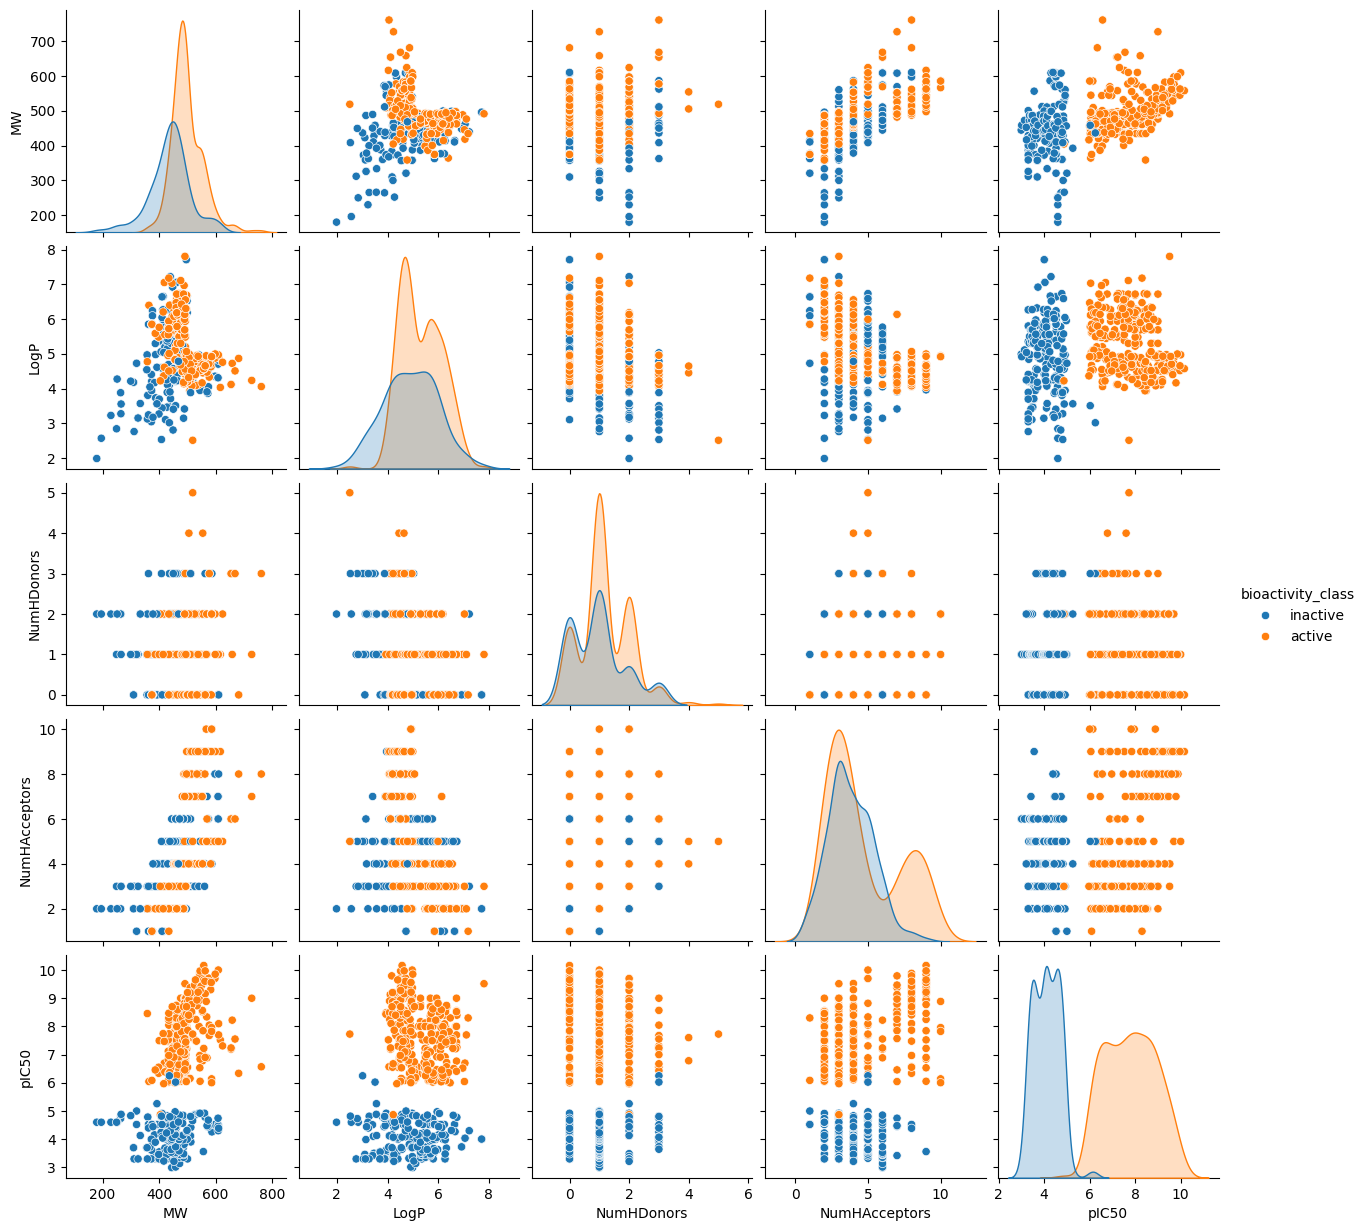

In [31]:
sns.pairplot(df_activity, hue="bioactivity_class")

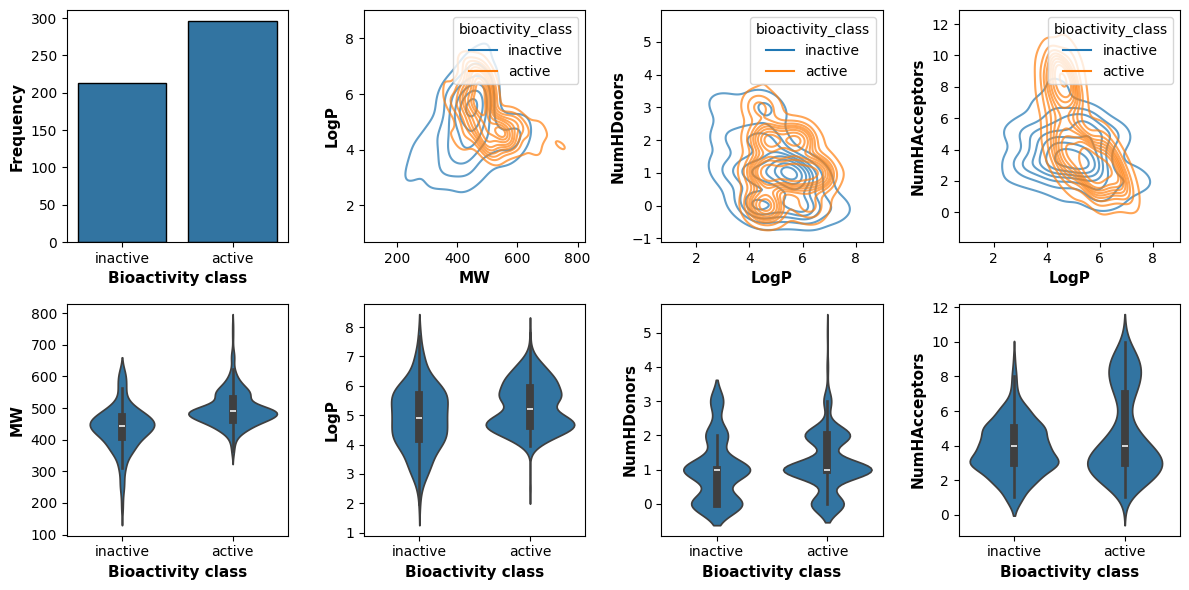

In [32]:
# Create 8 plots in 2x4 grid
fig, axs = plt.subplots(2, 4, figsize=(12, 6))

# Plot 1
sns.countplot(x='bioactivity_class', data=df_activity, edgecolor='black', ax=axs[0,0])
axs[0,0].set_xlabel('Bioactivity class', fontsize=11, fontweight='bold')
axs[0,0].set_ylabel('Frequency', fontsize=11, fontweight='bold')

# Plot 2
sns.kdeplot(x='MW', y='LogP',
                data=df_activity,
                hue='bioactivity_class',
                # size='pIC50',
                edgecolor='black', alpha=0.7, ax=axs[0,1])
axs[0,1].set_xlabel('MW', fontsize=11, fontweight='bold')
axs[0,1].set_ylabel('LogP', fontsize=11, fontweight='bold')
# axs[0,1].legend(bbox_to_anchor=(1.05, 1), loc="upper right", borderaxespad=0, fontsize=5)

# Plot 3
# sns.distplot(df_activity["LogP"],ax=axs[0,2])
# axs[0,2].set_xlabel('LogP', fontsize=11, fontweight='bold')
sns.kdeplot(x='LogP', y='NumHDonors',
                data=df_activity,
                hue='bioactivity_class',
                # size='LogP',
                edgecolor='black', alpha=0.7, ax=axs[0,2])
axs[0,2].set_xlabel('LogP', fontsize=11, fontweight='bold')
axs[0,2].set_ylabel('NumHDonors', fontsize=11, fontweight='bold')
# axs[0,2].legend(bbox_to_anchor=(1.05, 1), loc="upper right", borderaxespad=0, fontsize=5)

# Plot 4
sns.kdeplot(x='LogP', y='NumHAcceptors',
                data=df_activity,
                hue='bioactivity_class',
                # size='MW',
                edgecolor='black', alpha=0.7, ax=axs[0,3])
axs[0,3].set_xlabel('LogP', fontsize=11, fontweight='bold')
axs[0,3].set_ylabel('NumHAcceptors', fontsize=11, fontweight='bold')
# axs[0,3].legend(bbox_to_anchor=(1.05, 1), loc="upper right", borderaxespad=0, fontsize=5)

# Plot 5
sns.violinplot(x = 'bioactivity_class', y = 'MW', data = df_activity, ax=axs[1,0])
axs[1,0].set_xlabel('Bioactivity class', fontsize=11, fontweight='bold')
axs[1,0].set_ylabel('MW', fontsize=11, fontweight='bold')

# Plot 6
sns.violinplot(x = 'bioactivity_class', y = 'LogP', data = df_activity, ax=axs[1,1])
axs[1,1].set_xlabel('Bioactivity class', fontsize=11, fontweight='bold')
axs[1,1].set_ylabel('LogP', fontsize=11, fontweight='bold')


# Plot 7
sns.violinplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_activity, ax=axs[1,2])
axs[1,2].set_xlabel('Bioactivity class', fontsize=11, fontweight='bold')
axs[1,2].set_ylabel('NumHDonors', fontsize=11, fontweight='bold')

# Plot 8
sns.violinplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_activity, ax=axs[1,3])
axs[1,3].set_xlabel('Bioactivity class', fontsize=11, fontweight='bold')
axs[1,3].set_ylabel('NumHAcceptors', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


## Statistical Analysis

In order to design the most potent anti-cancer drugs, we need to identify the molecular characteristics by which the active molecules differ from the inactive molecules. Ideally, we would like to perform a [two sample T-test](https://www.statology.org/two-sample-t-test/) between the "active" and "inactive" groups using each of the molecular descriptors. To do this, the data must meet the following assumptions of the T-Test:
1. **Independence of Observations**: The observations between the two samples should be independent.
  - The data meets this as the activity of one molecule does not depend on the activity of another.
2. **Normality**: The data for each of the two groups should be approximately normally distributed.
  - The [Shapiro-Wilk test](https://builtin.com/data-science/shapiro-wilk-test) can be used to check this.
3. **Homogeneity of Variance**: The variances of the two groups should be equal in the population.
  - [Levene’s test](https://www.statisticshowto.com/levene-test/) or [Bartlett’s test](https://en.wikipedia.org/wiki/Bartlett's_test) can be used to check this, with Levene's test being more lenient to departures from normal distributed data.

In [33]:
# from pandas.core.frame import dataclasses_to_dicts

def shapiro_wilk_test(descriptors: list,
                      dataframe: pd.DataFrame,
                      out_dir: str):
  from scipy.stats import shapiro
  test_dict = dict()
  results_df = pd.DataFrame()
  for descriptor in descriptors:
    selection = [descriptor, 'bioactivity_class']
    df = dataframe[selection]
    # active group
    active = df[df['bioactivity_class'] == 'active']
    test_dict["active"] = active[descriptor]
    # inactive group
    inactive = df[df['bioactivity_class'] == 'inactive']
    test_dict["inactive"] = inactive[descriptor]
    for group in test_dict.keys():
      stat, p = shapiro(test_dict[group])
      stat, p = round(stat,4), round(p,4)
      alpha = 0.05
      if p > alpha:
          interpretation = 'Distribution is normally distributed (fail to reject H0)'
      else:
          interpretation = 'Distribution is not normally distributed (reject H0)'
      results = pd.DataFrame({'Group' : group,
                              'Descriptor':descriptor,
                              'Statistics':stat,
                              'p':p,
                              'alpha':alpha,
                              'Interpretation':interpretation}, index=[0])
      results_df = results_df.append(results)
  results_df_out = results_df
  filename = 'shapirowilk' + descriptor + '.csv'
  results_df.to_csv(out_dir / filename)
  return results_df_out

In [34]:
shapiro_wilk_test_results = shapiro_wilk_test(descriptors=['pIC50', 'MW', 'LogP', 'NumHDonors', 'NumHAcceptors'], dataframe=df_activity,out_dir=csv_path)
shapiro_wilk_test_results

,Group,Descriptor,Statistics,p,alpha,Interpretation
0,active,pIC50,0.97,0.00,0.05,Distribution is not normally distributed (reje...
0,inactive,pIC50,0.96,0.00,0.05,Distribution is not normally distributed (reje...
0,active,MW,0.93,0.00,0.05,Distribution is not normally distributed (reje...
0,inactive,MW,0.96,0.00,0.05,Distribution is not normally distributed (reje...
0,active,LogP,0.96,0.00,0.05,Distribution is not normally distributed (reje...
0,inactive,LogP,1.00,0.72,0.05,Distribution is normally distributed (fail to ...
0,active,NumHDonors,0.85,0.00,0.05,Distribution is not normally distributed (reje...
0,inactive,NumHDonors,0.83,0.00,0.05,Distribution is not normally distributed (reje...
0,active,NumHAcceptors,0.85,0.00,0.05,Distribution is not normally distributed (reje...
0,inactive,NumHAcceptors,0.95,0.00,0.05,Distribution is not normally distributed (reje...


The data distributions within this dataset are (generally) not normally distributed, violating the assumptions required to perform a T test. Therefore, the [Mann-Whitney U Test](https://statistics.laerd.com/statistical-guides/mann-whitney-u-test-assumptions.php) will be used instead. This statistical test is less powerful than the T test and compares distribution shapes instead of differences in means, but does not require normally distributed data.

In [35]:
def mann_whitney_u_test(descriptors: list,
                      dataframe: pd.DataFrame,
                      out_dir: str):
  from scipy.stats import mannwhitneyu
  test_dict = dict()
  results_df = pd.DataFrame()
  for descriptor in descriptors:
    selection = [descriptor, 'bioactivity_class']
    df = dataframe[selection]
    # active group
    active = df[df['bioactivity_class'] == 'active']
    test_dict["active"] = active[descriptor]
    # inactive group
    inactive = df[df['bioactivity_class'] == 'inactive']
    test_dict["inactive"] = inactive[descriptor]
    stat, p = mannwhitneyu(test_dict["active"],test_dict["inactive"])
    stat, p = round(stat,4), round(p,4)
    alpha = 0.05
    if p > alpha:
      interpretation = 'Same distribution (fail to reject H0)'
    else:
      interpretation = 'Different distribution (reject H0)'
    results = pd.DataFrame({'Descriptor':descriptor,
                            'Statistics':stat,
                            'p':p,
                            'alpha':alpha,
                            'Interpretation':interpretation}, index=[0])
    results_df = results_df.append(results)
  results_df_out = results_df
  filename = 'mannwhitneyu' + descriptor + '.csv'
  results_df.to_csv(out_dir / filename)
  return results_df_out

In [36]:
mann_whitney_u_test_results = mann_whitney_u_test(descriptors=['pIC50', 'MW', 'LogP', 'NumHDonors', 'NumHAcceptors'], dataframe=df_activity,out_dir=csv_path)
mann_whitney_u_test_results

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,63010.00,0.00,0.05,Different distribution (reject H0)
0,MW,48459.00,0.00,0.05,Different distribution (reject H0)
0,LogP,38668.50,0.00,0.05,Different distribution (reject H0)
0,NumHDonors,36393.00,0.00,0.05,Different distribution (reject H0)
0,NumHAcceptors,35294.00,0.02,0.05,Different distribution (reject H0)


## Fingerprint Descriptors

To analyse the chemical properties of the active and inactive molecules in more details, we need to obtain the molecular fingerprints for each molecule using PaDEL. This requires creating a "molecule.smi" CSV file which contains SMILES notations for the molecular structures and will be read by PaDEL and used to create a dataframe of molecular fingerprints for each molecule.

In [37]:
# Create molecule.smi file for PaDEL analysis
df_activity_selection = df_activity[['canonical_smiles','molecule_chembl_id']]
df_activity_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

def get_file_size(file_path):
  file_size = os.path.getsize(file_path)
  if file_size == 0:
      return "0B"
  size_name = ("B", "KB", "MB", "GB")
  i = int(math.floor(math.log(file_size, 1024)))
  p = math.pow(1024, i)
  s = round(file_size / p, 2)
  return f'{s} {size_name[i]}'
print(f"Molecules file size: {get_file_size('molecule.smi')}")

Molecules file size: 39.89 KB


In [38]:
lipinski_df = pd.read_csv(csv_path / "bioactivity_data_non_intermediate_with_pIC50_Lipinski_pass.csv")
lipinski_df.head()

,Unnamed: 0,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,1,CHEMBL360920,CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccccc1)c1ccc(C(C)...,inactive,426.56,5.48,1.00,2.00,4.18
1,2,CHEMBL182052,CCCOC1(c2ccccc2)c2ccccc2C(=O)N1C(Cc1ccc(O)cc1)...,inactive,445.52,4.26,1.00,5.00,4.05
2,3,CHEMBL179662,OCC(NC1(c2ccccc2)c2ccccc2CC1Cc1ccccc1)C(O)c1cc...,inactive,449.59,5.03,3.00,3.00,4.07
3,4,CHEMBL181688,CC(C)(C)c1ccc(COC2(c3ccccc3)c3ccccc3C(=O)N2Cc2...,inactive,461.61,7.06,0.00,2.00,4.04
4,5,CHEMBL179114,COc1ccc(C(O)CNC2(c3ccccc3)c3ccccc3C(=O)N2Cc2cc...,inactive,464.57,4.88,2.00,4.00,4.15


In [39]:
padelpy.padeldescriptor(descriptortypes="./padelpy-0.1.15/padelpy/PaDEL-Descriptor/descriptors.xml",
                        removesalt=True, # remove salt during descriptor calculation as these can interfere with calculation of molecular descriptors
                        fingerprints=True, # calculate fingerprints
                        standardizenitro=True, # standardise nitro groups
                        mol_dir=".", # input molecule.smi is in current directory
                        d_file=data_path / "descriptors_output.csv" # output file name
                        )

In [40]:
descriptor_df = pd.read_csv(data_path / 'descriptors_output.csv')
descriptor_df

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL360920,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL182052,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL179662,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL181688,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL179114,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,CHEMBL3649989,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
505,CHEMBL5070769,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
506,CHEMBL5085709,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
507,CHEMBL5208707,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Random Forest Regression

To be able to predict if a molecule will be active against PD1, we can use a random forest model trained on the ChEMBL fingerprint data for molecules that pass the Lipinski Rule of Five and show activity/inactivity against PD1. Whether a compound is active or inactive will be determined based on its pIC50 value.

In [41]:
df3_X = descriptor_df.drop(columns=['Name'])
df3_Y = lipinski_df['pIC50'] # prediction values
dataset3 = pd.concat([df3_X,df3_Y], axis=1) # store all data in dataframe
dataset3.to_csv('pd1_bioactivity_data_3class_pIC50_pubchem_fp.csv', index=False)

In [42]:
fp_df = pd.read_csv('pd1_bioactivity_data_3class_pIC50_pubchem_fp.csv')
Y = fp_df.pIC50
print(Y)
X = fp_df.drop('pIC50', axis=1) # drop this column as X data will be used for training
print(X)

0     4.18
1     4.05
2     4.07
3     4.04
4     4.15
      ... 
504   8.70
505   6.14
506   6.00
507   7.44
508   7.73
Name: pIC50, Length: 509, dtype: float64
     PubchemFP0  PubchemFP1  PubchemFP2  PubchemFP3  PubchemFP4  PubchemFP5  \
0             1           1           1           0           0           0   
1             1           1           1           0           0           0   
2             1           1           1           0           0           0   
3             1           1           1           0           0           0   
4             1           1           1           0           0           0   
..          ...         ...         ...         ...         ...         ...   
504           1           1           1           0           0           0   
505           1           1           1           1           0           0   
506           1           1           1           1           0           0   
507           1           1           1         

In [43]:
print(X.shape, Y.shape)

(509, 881) (509,)


In [44]:
# remove low variance fingerprint features that provide little information but increase data size
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))
X = selection.fit_transform(X)

In [45]:
X.shape

(509, 150)

In [46]:
# Create train test plit
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [47]:
print(f"Train data: {X_train.shape}, {Y_train.shape}")
print(f"Test data: {X_test.shape}, {Y_test.shape}")

Train data: (407, 150), (407,)
Test data: (102, 150), (102,)


In [48]:
# Random Forest Regression
np.random.seed(42)
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, Y_train)
rf_r2 = rf_model.score(X_test, Y_test)
rf_r2

0.8555213924309221

In [49]:
rf_Y_pred = rf_model.predict(X_test)
print(rf_Y_pred.shape)

(102,)


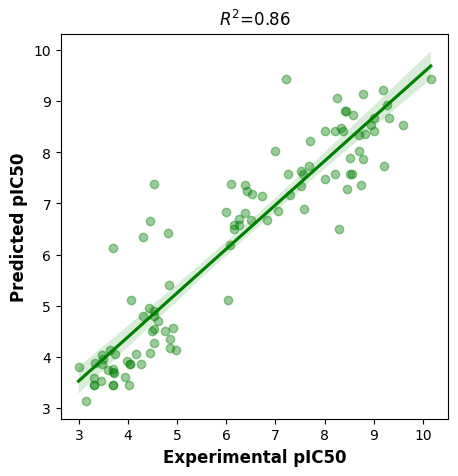

In [50]:
# min_test = math.floor(min(Y_test) - 0.5)
# min_pred = math.floor(min(Y_pred) - 0.5)
# max_test = math.ceil(max(Y_test) + 0.5)
# max_pred = math.ceil(max(Y_pred) + 0.5)

ax = sns.regplot(x=Y_test, y=rf_Y_pred, scatter_kws={'alpha':0.4}, color="green")
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
# ax.set_xlim(min_test, max_test)
# ax.set_ylim(min_pred, max_pred)
ax.figure.set_size_inches(5, 5)
plt.title(f"$R^2$={rf_r2:.2f}")
plt.show()

In [51]:
# Y = fp_df.pIC50
# X = fp_df.drop('pIC50', axis=1)
# print(X.shape, Y.shape)

In [52]:
# selection = VarianceThreshold(threshold=(.8 * (1 - .8)))
# X = selection.fit_transform(X)
# print(X.shape)

In [53]:
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [54]:
clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None) # Defines and builds the lazyclassifier
models_train,predictions_train = clf.fit(X_train, X_train, Y_train, Y_train)
models_test,predictions_test = clf.fit(X_train, X_test, Y_train, Y_test)

100%|██████████| 42/42 [00:13<00:00,  3.20it/s]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 450
[LightGBM] [Info] Number of data points in the train set: 407, number of used features: 150
[LightGBM] [Info] Start training from score 6.280485
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

100%|██████████| 42/42 [00:12<00:00,  3.37it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 450
[LightGBM] [Info] Number of data points in the train set: 407, number of used features: 150
[LightGBM] [Info] Start training from score 6.280485
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [55]:
print(predictions_train.head(10))

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          0.92       0.95  0.45        0.67
DecisionTreeRegressor                        0.92       0.95  0.45        0.06
ExtraTreeRegressor                           0.92       0.95  0.45        0.03
GaussianProcessRegressor                     0.92       0.95  0.45        0.12
XGBRegressor                                 0.92       0.95  0.45        0.20
RandomForestRegressor                        0.90       0.94  0.51        0.62
BaggingRegressor                             0.89       0.93  0.55        0.08
LGBMRegressor                                0.88       0.92  0.57        0.17
HistGradientBoostingRegressor                0.88       0.92  0.57        0.47
GradientBoostingRegressor                    0.87       0.92  0.57        0.32




`predictions_test` generated some R^2 values greater than 1, indicating invalid models, as explained here https://stats.stackexchange.com/questions/334004/can-r2-be-greater-than-1

Therefore Remove R^2 greater than 1.0 .



In [56]:
predictions_test2 = predictions_test[(predictions_test["R-Squared"] <= 1.0) & (predictions_test["R-Squared"] >= 0.0)]
print(predictions_test2.sort_values(by="Adjusted R-Squared").head(20))

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GradientBoostingRegressor                    1.26       0.87  0.73        0.28
XGBRegressor                                 1.27       0.87  0.75        0.20
HistGradientBoostingRegressor                1.27       0.87  0.76        0.48
SGDRegressor                                 1.27       0.87  0.76        0.03
LGBMRegressor                                1.28       0.87  0.76        0.12
BayesianRidge                                1.28       0.86  0.77        0.05
PoissonRegressor                             1.28       0.86  0.77        0.25
ElasticNetCV                                 1.29       0.86  0.77        2.30
RidgeCV                                      1.29       0.86  0.78        0.05
MLPRegressor                                 1.29       0.86  0.78        1.37
LassoCV                                      1.29   

[(0.0, 1.0)]

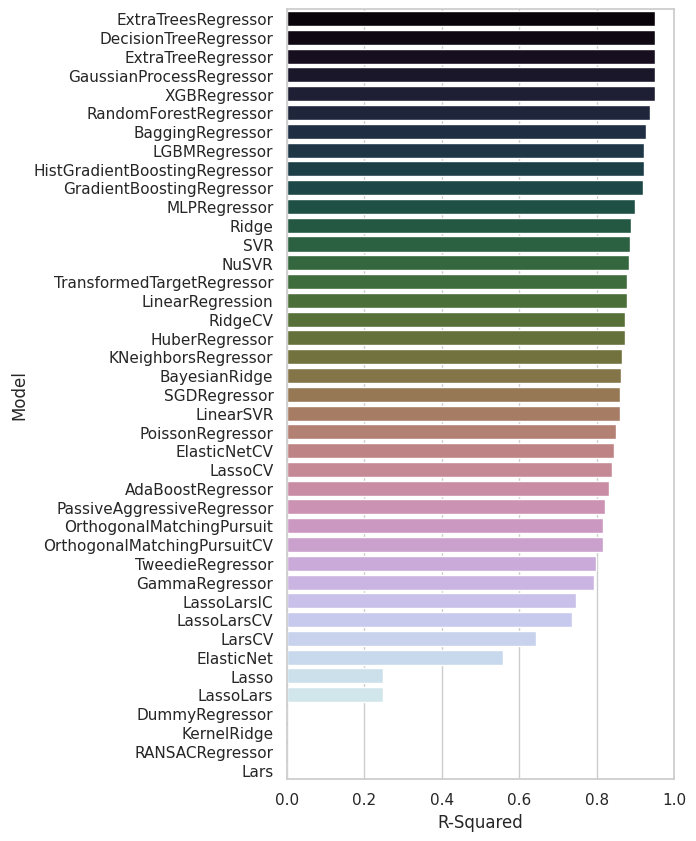

In [57]:
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="R-Squared", data=predictions_train, palette = "cubehelix")
ax.set(xlim=(0, 1))

[(0.0, 10.0)]

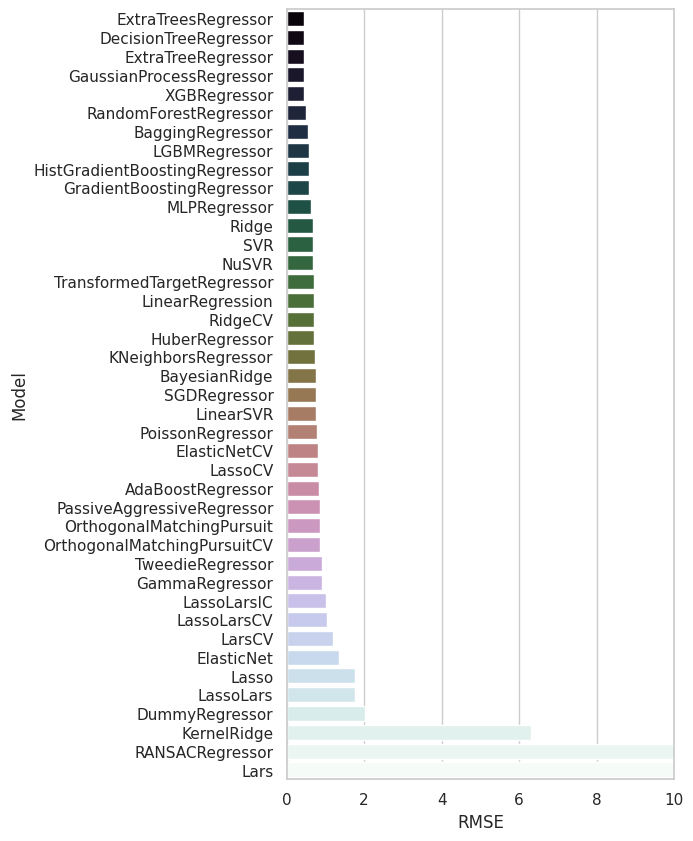

In [58]:
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="RMSE", data=predictions_train, palette = "cubehelix")
ax.set(xlim=(0, 10))

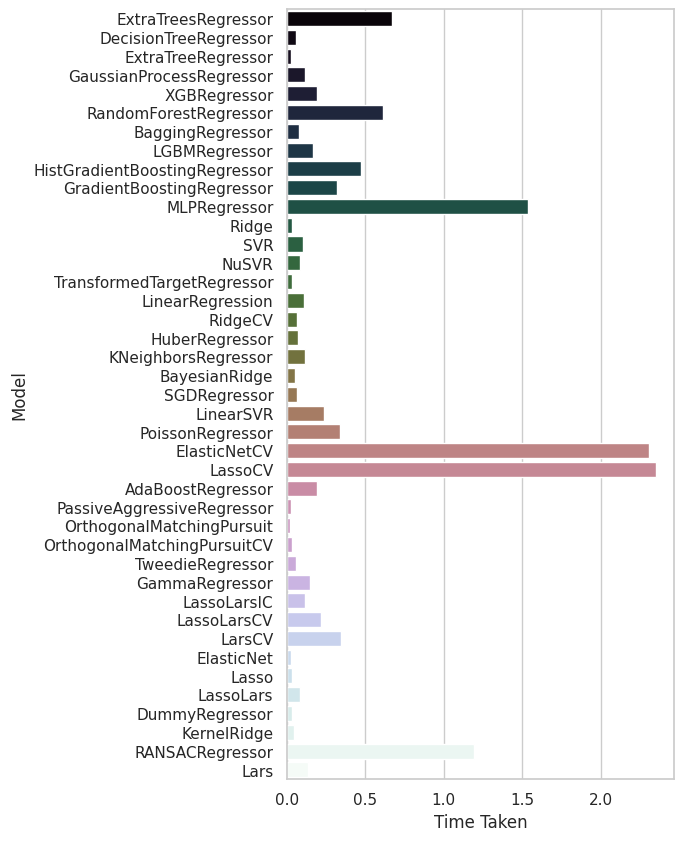

In [59]:
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="Time Taken", data=predictions_train, palette = "cubehelix")
# ax.set(xlim=(0, 10))

GaussianProcessRegressor has higher R^2 than RandomForest and reduced computation time - let's see how that works instead of RandomForest

In [60]:
from sklearn.gaussian_process import GaussianProcessRegressor
import numpy as np
gp_model = GaussianProcessRegressor() # Create a Gaussian Process Regressor
gp_model.fit(X_train, Y_train) # Fit the regressor to data
gp_Y_pred = gp_model.predict(X_test) # Predict using the trained regressor
gp_r2 = gp_model.score(X_test, gp_Y_pred) # Get r squared value
print(gp_r2)

1.0


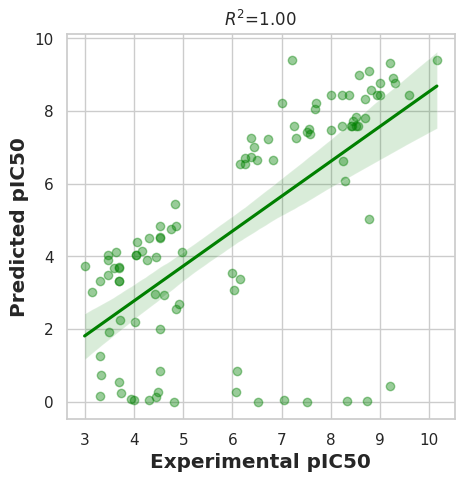

In [61]:
ax = sns.regplot(x=Y_test, y=gp_Y_pred, scatter_kws={'alpha':0.4}, color="green")
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.figure.set_size_inches(5, 5)
plt.title(f"$R^2$={gp_r2:.2f}")
plt.show()

An R^2 of 1 suggests high predictive accuracy, however due to the relatively small train and test datasets, this could be partly due to overfitting. However, in theory this model could be used to predict pIC50 values when provided with a given molecular fingerprint. Using the pIC50 values to infer bioactivity, this could (theoretically) indicate potential new therapeutics targeting p53 or other proteins that are involved in cancer.

Additionally, the Gaussion Process Regressor may not be statistical applicable to our data, rendering any predictions here invalid and unlikely to sustain high perform on larger datasets. Information of Gaussian Process Regressor:
1. https://stats.stackexchange.com/questions/400783/gaussian-processes-a-crucial-assumption
2. https://scikit-learn.org/stable/modules/gaussian_process.html
3. ["In probability theory and statistics, a Gaussian process is a stochastic process (a collection of random variables indexed by time or space), such that every finite collection of those random variables has a multivariate normal distribution, i.e. every finite linear combination of them is normally distributed."](https://en.wikipedia.org/wiki/Gaussian_process) - this suggests that this method may not be appropriate for our current non-normally distributed data. However in larger datasets, the data (and random subsets thereof) may be normally distributed, and therefore this method could be reassessed for use if a larger dataset is studied.